In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data cleaning and visualization

In [110]:
df = pd.read_csv("/content/ARIMA-And-Seasonal-ARIMA/perrin-freres-monthly-champagne-.csv")

In [111]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [112]:
df.columns = ["Month", "Sales"]

In [113]:
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [114]:
df.tail()

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [115]:
df.drop(106, axis=0, inplace=True)

In [116]:
df.isnull().sum()

Month    1
Sales    1
dtype: int64

In [117]:
df = df.dropna()

In [118]:
df.isnull().sum()

Month    0
Sales    0
dtype: int64

In [119]:
df["Month"] = pd.to_datetime(df["Month"])

In [120]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [121]:
df.set_index("Month", inplace=True)

In [122]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [123]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,105.0,4761.152381,2553.502601,1413.0,3113.0,4217.0,5221.0,13916.0


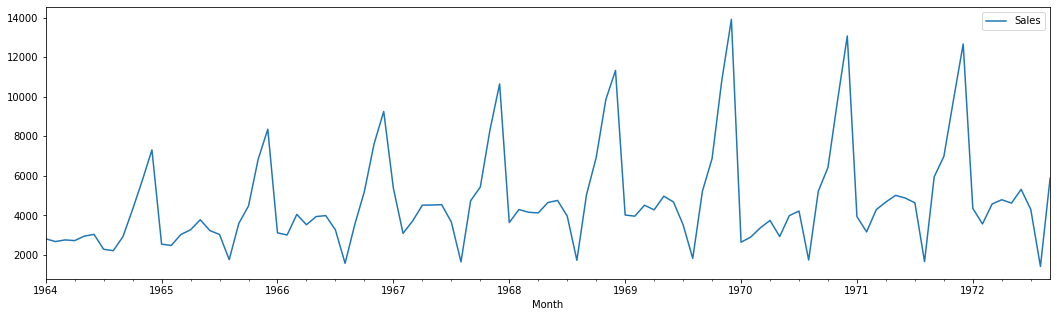

In [124]:
df.plot(figsize=(18,5));

## Testing for stationarity

In [125]:
from statsmodels.tsa.stattools import adfuller

In [126]:
test_result = adfuller(df["Sales"])
test_result

(-1.8335930563276188,
 0.363915771660247,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [127]:
# H0 -> Non stationary
# H1 -> Stationary
def adfuller_test(sales):
  result = adfuller(sales)
  labels = ["ADF Test Statistic", "p-value", "#Lags used", "Number of observations Used"]
  for value,label in zip(result, labels):
    print(label + ' : ' + str(value))
  if (result[1] <= 0.05):
    print("H0 is rejected! Data is stationary")
  else:
    print("H0 is accepted! Data is not stationary")

In [128]:
adfuller_test(df["Sales"])

ADF Test Statistic : -1.8335930563276188
p-value : 0.363915771660247
#Lags used : 11
Number of observations Used : 93
H0 is accepted! Data is not stationary


## Differencing (to convert non stationary data to stationary data)

In [129]:
df["Sales First Difference"] = df["Sales"] - df["Sales"].shift(1)
df["Seasonal First Difference"] = df["Sales"] - df["Sales"].shift(12)

In [130]:
df.head()

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [131]:
adfuller_test(df["Seasonal First Difference"].dropna())

ADF Test Statistic : -7.626619157213166
p-value : 2.0605796968136632e-11
#Lags used : 0
Number of observations Used : 92
H0 is rejected! Data is stationary


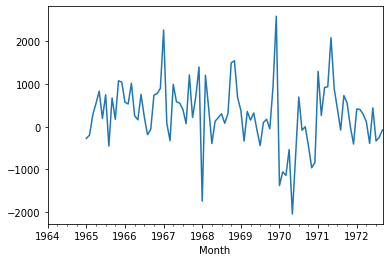

In [132]:
df["Seasonal First Difference"].plot();

## Plotting PACF(for AR model) and ACF(for MA model) values

In [133]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

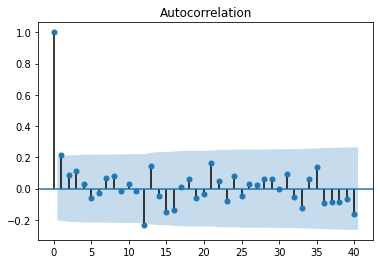

In [134]:
plot_acf(df["Seasonal First Difference"].dropna(), lags=40);

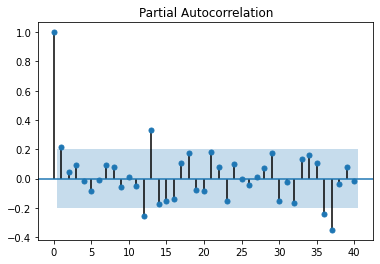

In [135]:
plot_pacf(df["Seasonal First Difference"].dropna(), lags=40);

## SARIMAX Model

In [136]:
import warnings
warnings.filterwarnings("ignore")

In [137]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [138]:
model = SARIMAX(df["Sales"], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

In [139]:
len(df)

105

## Predicting sales for 90 to 105 df index

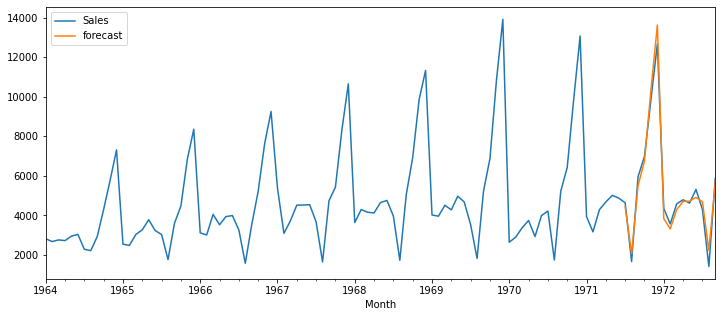

In [140]:
df["forecast"] = results.predict(start=90, end=105, dynamic=True)
df[["Sales", "forecast"]].plot(figsize=(12,5));

In [141]:
df.tail()

,Sales,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1972-05-01,4618.0,-170.0,-392.0,4717.512497
1972-06-01,5312.0,694.0,438.0,4906.404885
1972-07-01,4298.0,-1014.0,-335.0,4685.437992
1972-08-01,1413.0,-2885.0,-246.0,2232.409287
1972-09-01,5877.0,4464.0,-74.0,5686.558595


## Add 24 months to the data

In [156]:
from pandas.tseries.offsets import DateOffset

In [157]:
temp = df.index + DateOffset(months=24)

In [158]:
temp = temp[-24:]

In [159]:
df.tail()

,Sales,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1972-05-01,4618.0,-170.0,-392.0,4717.512497
1972-06-01,5312.0,694.0,438.0,4906.404885
1972-07-01,4298.0,-1014.0,-335.0,4685.437992
1972-08-01,1413.0,-2885.0,-246.0,2232.409287
1972-09-01,5877.0,4464.0,-74.0,5686.558595


In [160]:
temp

DatetimeIndex(['1972-10-01', '1972-11-01', '1972-12-01', '1973-01-01',
               '1973-02-01', '1973-03-01', '1973-04-01', '1973-05-01',
               '1973-06-01', '1973-07-01', '1973-08-01', '1973-09-01',
               '1973-10-01', '1973-11-01', '1973-12-01', '1974-01-01',
               '1974-02-01', '1974-03-01', '1974-04-01', '1974-05-01',
               '1974-06-01', '1974-07-01', '1974-08-01', '1974-09-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [164]:
temp_df = pd.DataFrame(temp, columns = ["Month", "Sales", "Sales First Difference", "Seasonal First Difference", "forecast"])
temp_df = temp_df.set_index("Month")
temp_df.head()

,Sales,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN


In [165]:
final_df = pd.concat([df, temp_df], axis=0)
final_df.head()

,Sales,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN


In [169]:
len(final_df)

129

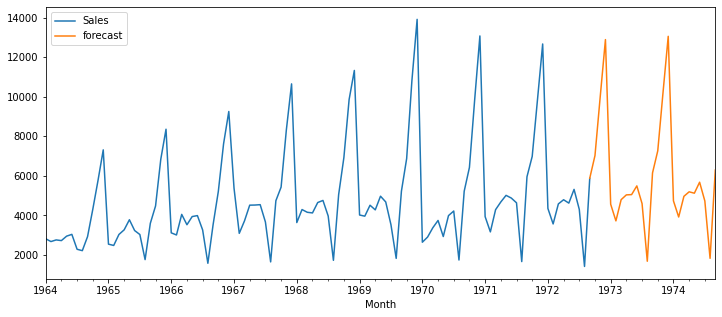

In [175]:
final_df["forecast"] = results.predict(start=104, end=129, dynamic=True)
final_df[["Sales", "forecast"]].plot(figsize=(12,5));